# Post-TFM

The main idea of this notebook is to try the ideas Alba has presented. Some of them includes: 

1. Find a relation between the equal outcome probabilities of subspaces A and B with the Schmidt coefficients. The idea is to try to combine somehow the VQSVD with these randomized methods.

2. Implement the $p_3$ moment. For that, we should revisit the expression given in the work.

3. Run the protocols in IBM quantum processors. We must translate the code into Qiskit. It will only serve to know what to expect from these random procedures.

4. Understand and program this paper arXiv:1908.05251.

Estas ideas se implementarán en cualquier orde, que seguro que me atasco por todos los lados.


## Tests on Schmidt coeff.

I deleted everything becasuse anything worked and I am not proud enough with the resukts to show them.

## Tests on $p_3$ moments

We recommend my master thesis and this paper arXiv:2007.06305v2 for more info on the matter. We can only estimate p3 using the Global approach to extrac the statistic. Local approach can be implemented but requieres a similar appraoch to tomography. It works better than tomogrpahy but it is still not that good.

In [3]:
#useful functions
def all_binary_iterations(total_bits):
    if total_bits <= 0:
        raise ValueError("Total bits must be greater than zero.")

    max_value = 2**total_bits - 1
    binary_iterations = []

    for i in range(max_value + 1):
        binary_string = bin(i)[2:].zfill(total_bits)
        binary_iterations.append(binary_string)

    return binary_iterations

In [4]:
#this function is very useful and can be rewriten to find expressions for higer pn-moments. Check my TFM
#Is it useful to find the tr(rho?3) formula.
def find_bl_combinations(target_sum):
    # Initialize the list to store all combinations of bl values
    bl_combinations = []
    
    # Loop through all possible combinations of bl values (0 to target_sum) for l=1,2,3
    for b1 in range(target_sum + 1):
        for b2 in range(target_sum + 1):
            for b3 in range(target_sum + 1):
                # Check if the equation is satisfied
                if (1 * b1 + 2 * b2 + 3 * b3) == target_sum:
                    bl_combinations.append((b1, b2, b3))
    
    return bl_combinations

# Find all combinations of bl values that satisfy the equation sum(l * bl) = 3
target_sum = 3
combinations = find_bl_combinations(target_sum)

# Print the results
for combination in combinations:
    print(f"b1 = {combination[0]}, b2 = {combination[1]}, b3 = {combination[2]}")

b1 = 0, b2 = 0, b3 = 1
b1 = 1, b2 = 1, b3 = 0
b1 = 3, b2 = 0, b3 = 0


Here we start with some runs and test the p3-moment with the expected one. You can find a rough implementation of the code.

In [1]:
from mycircuits import GHZ
from myfunctions import Randomized_Renyi_2 as random_renyi2
import numpy as np
from qibo.models import Circuit

In [7]:
nqubits = 6     #number of qubits
c = GHZ(nqubits)        #circuit execution for the GHZ state
copy = c.copy()

matrix = copy.unitary()     #quantum state as a matrix. Useful math operations

f = random_renyi2()
N_A = [0,1,2]
N_U = 1000
N_M = 256

f.Global(c, N_A, N_U, N_M)      #execution of the Global random protocol

entropy = f.entropy()
purity = 2**(-entropy)
freq = f.frequencies()

lista_p = []
bits = all_binary_iterations(3)
for i in range(len(freq)):
    iter_u = 0
    for j in bits:
        p = freq[i][str(j)]/N_M
        iter_u += (2*p - 3*N_M*p**2 + N_M**2*p**3)/((N_M - 1)*(N_M - 2))

    lista_p.append(iter_u)

mean = np.mean(lista_p)

p3 = 0.5*((2**3 + 1)*(2**3 + 2)*mean - 3*purity - 1) 

initial_state = np.zeros(shape = (2**nqubits, 2**nqubits))
initial_state[0,0] = 1
final_state = matrix @ initial_state @ matrix.T.conj()
#print(final_state)

n1, n2 = int(len(N_A)), int(nqubits-len(N_A))       #está hecho para partir A y B por la mitad just. De otra manera ni idea.
reshaped_psi = np.reshape(final_state, [2**n1, 2**n2, 2**n1, 2**n2])
rho_A = np.trace(reshaped_psi, axis1=1, axis2=3)
#print(rho_A)

U, D, V_dagger = np.linalg.svd(rho_A, full_matrices=True)

#print(D)

puri = 0
cubbed = 0
for i in range(len(D)):
    puri += D[i]**2
    cubbed += D[i]**3

print('Real: ', puri, 'Estimated: ', purity, 'Diff: ', np.abs(puri - purity))
print('Real: ', cubbed, 'Estimated: ', p3, 'Diff: ', np.abs(cubbed - p3))

[Qibo 0.1.12.dev0|INFO|2023-09-13 13:33:52]: Using qibojit (numba) backend on /CPU:0


Real:  0.4999999999999998 Estimated:  0.4999986213235294 Diff:  1.378676470376039e-06
Real:  0.24999999999999983 Estimated:  0.2537676405453917 Diff:  0.0037676405453918593


In [9]:
p2 = purity
if p3 < p2**2:
    print('State is entangled')

if p3 >= p2**2:
    print('Cannot tell if the state is entangled')

Cannot tell if the state is entangled


We find a problem when the initial state is pure, as $p_3$ and $p^2$ hold the same values. Thus, we should add some range of values where we consider the correct answer, or at least print the values so the usewr can check what is going on.

As everything seams to work fine, we have implemented the previous code into myfunctions.

In [10]:
#remember that only works for global
nqubits = 6
c = GHZ(nqubits)

f = random_renyi2()
N_A = [0,1,2]
N_U = 1000
N_M = 256

f.Global(c, N_A, N_U, N_M)
f.entanglement_checker()

p3 value:  0.25149507150301087
p^2 value:  0.2556803423461914
State is entangled


Here, we get an entangled state because of the values we got, but equality should have been found instead.

We can test it into the Werner state and check if it works fine.

In [17]:
p = 0.2        #for p<1/2, the state is entangled. It is separable for p>=1/2.
Werner_matrix = np.array([[p/3, 0, 0, 0],[0, (3-2*p)/6, (-3+4*p)/6, 0],[0, (-3+4*p)/6, (3-2*p)/6, 0],[0, 0, 0, p/3]])
Werner_matrix_TA = np.array([[p/3, 0, 0, (-3+4*p)/6],[0, (3-2*p)/6, 0, 0],[0, 0, (3-2*p)/6, 0],[(-3+4*p)/6, 0, 0, p/3]])

print('Matrix representation of W_AB^T_A')
print(Werner_matrix_TA)

c = Circuit(2, density_matrix=True)

result = c(Werner_matrix_TA, nshots= 1000)

print(result)

#a = (3-2*p)/6
#b = (-3+4*p)/6

#exp_p2 = 2*(b**2 + p**2/9 + a**2)
#exp_p3 = 2*(a**3+p*b**2+p**3/27)

W2 = Werner_matrix_TA @ Werner_matrix_TA
p2 = np.trace(W2)
W3 = W2 @ Werner_matrix_TA
p3 = np.trace(W3)
print('Exact p2: ', p2)
print('Exact p3: ', p3)


Matrix representation of W_AB^T_A
[[ 0.06666667  0.          0.         -0.36666667]
 [ 0.          0.43333333  0.          0.        ]
 [ 0.          0.          0.43333333  0.        ]
 [-0.36666667  0.          0.          0.06666667]]
(0.06667+0j)|00><00| + (-0.36667+0j)|00><11| + (0.43333+0j)|01><01| + (0.43333+0j)|10><10| + (-0.36667+0j)|11><00| + (0.06667+0j)|11><11|
Exact p2:  0.6533333333333334
Exact p3:  0.21711111111111114


In [19]:
#Here is the implementation in myfunctions
f = random_renyi2()
N_A = [0,1]
N_U = 1000  
N_M = 1000

f.Global_matrix(N_A, N_U, N_M, Werner_matrix_TA)
f.entanglement_checker()

p3 value:  0.223595068756131
p^2 value:  0.2718544944494829
State is entangled


In [24]:
lambdas = np.linspace(0,1,10)        #for p<1/2, the state is entangled. It is separable for p>=1/2.
lista_expected_p3 = []
lista_expected_p2 = []
lista_estimated_p3 = []
lista_estimated_p2 = []
for p in lambdas:
    Werner_matrix = np.array([[p/3, 0, 0, 0],[0, (3-2*p)/6, (-3+4*p)/6, 0],[0, (-3+4*p)/6, (3-2*p)/6, 0],[0, 0, 0, p/3]])
    Werner_matrix_TA = np.array([[p/3, 0, 0, (-3+4*p)/6],[0, (3-2*p)/6, 0, 0],[0, 0, (3-2*p)/6, 0],[(-3+4*p)/6, 0, 0, p/3]])
    #print(Werner_matrix_TA)

    W2 = Werner_matrix_TA @ Werner_matrix_TA
    exp_p2 = np.trace(W2)
    W3 = W2 @ Werner_matrix_TA
    exp_p3 = np.trace(W3)
    lista_expected_p2.append(exp_p2)
    lista_expected_p3.append(exp_p3)

    f = random_renyi2()
    N_A = [0,1]
    N_U = 1000  
    N_M = 1000

    f.Global_matrix(N_A, N_U, N_M, Werner_matrix_TA)
    f.entanglement_checker()
    estimated_p3 = f.p3
    estimated_p2 = 2**(-1*f.entropy_value)
    lista_estimated_p2.append(estimated_p2)
    lista_estimated_p3.append(estimated_p3)

p3 value:  0.2941463077205463
p^2 value:  0.33862114702818763
State is entangled
Estimated p2 and p3 : 0.5819116316316315 0.2941463077205463
p3 value:  0.2551633884285087
p^2 value:  0.30369663553821696
State is entangled
Estimated p2 and p3 : 0.5510867767767768 0.2551633884285087
p3 value:  0.21199839769629336
p^2 value:  0.2571423695583475
State is entangled
Estimated p2 and p3 : 0.5070920720720721 0.21199839769629336
p3 value:  0.1701164055137303
p^2 value:  0.20045537650321402
State is entangled
Estimated p2 and p3 : 0.4477224324324324 0.1701164055137303
p3 value:  0.12995466699164093
p^2 value:  0.13968470772913547
State is entangled
Estimated p2 and p3 : 0.3737441741741742 0.12995466699164093
p3 value:  0.09406222490025085
p^2 value:  0.09039724819642075
Cannot tell if the state is entangled
Estimated p2 and p3 : 0.30066135135135136 0.09406222490025085
p3 value:  0.06918139242448884
p^2 value:  0.06739788223557702
Cannot tell if the state is entangled
Estimated p2 and p3 : 0.2596

In [4]:
import matplotlib.pyplot as plt

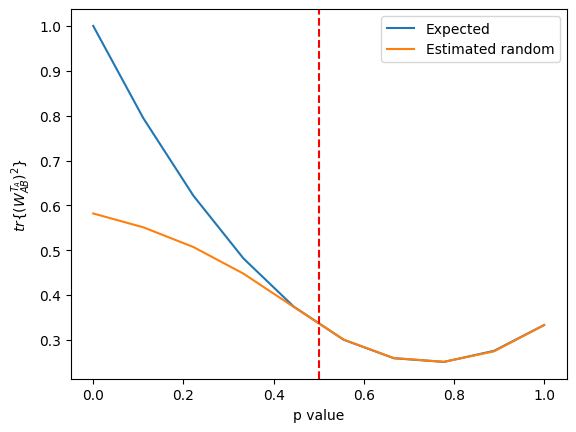

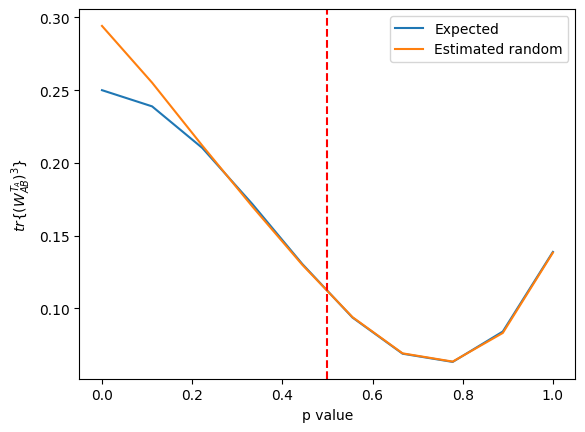

In [31]:
plt.plot(lambdas, lista_expected_p2, label = 'Expected')
plt.plot(lambdas, lista_estimated_p2, label = 'Estimated random')
plt.axvline(x = 1/2, linestyle='dashed', color = 'red')
plt.xlabel('p value')
plt.ylabel(r'$tr\{(W_{AB}^{T_A})^2\}$')
plt.legend()
plt.show()

plt.plot(lambdas, lista_expected_p3, label = 'Expected')
plt.plot(lambdas, lista_estimated_p3, label = 'Estimated random')
plt.axvline(x = 1/2, linestyle='dashed', color = 'red')
plt.xlabel('p value')
plt.ylabel(r'$tr\{(W_{AB}^{T_A})^3\}$')
plt.legend()
plt.show()

In [32]:
lambdas = np.linspace(0,1,10)
lambdas1 = (3-4*lambdas)/3

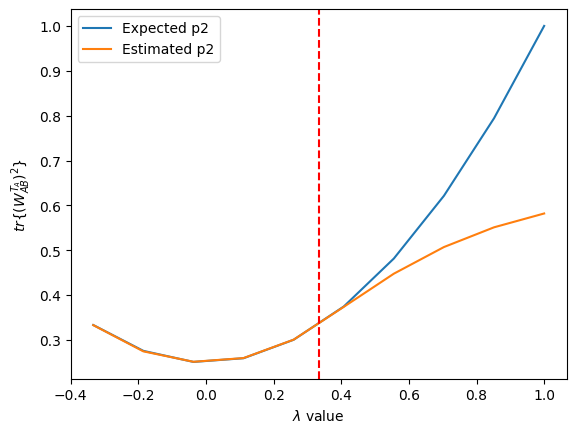

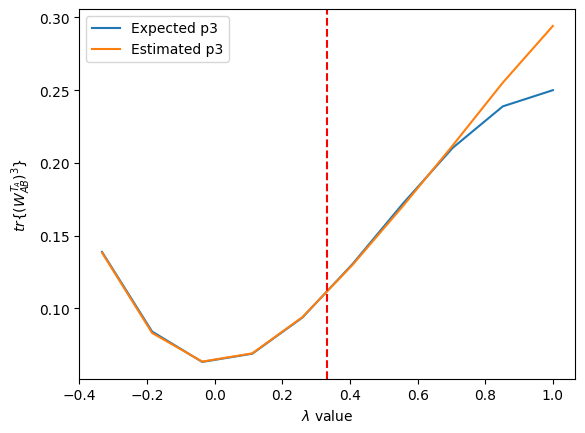

In [35]:
plt.plot(lambdas1, lista_expected_p2, label = 'Expected p2')
plt.plot(lambdas1, lista_estimated_p2, label = 'Estimated p2')
plt.axvline(x = 1/3, linestyle='dashed', color = 'red')
plt.xlabel('$\lambda$ value')
plt.ylabel(r'$tr\{(W_{AB}^{T_A})^2\}$')
plt.legend()
plt.show()

plt.plot(lambdas1, lista_expected_p3, label = 'Expected p3')
plt.plot(lambdas1, lista_estimated_p3, label = 'Estimated p3')
plt.axvline(x = 1/3, linestyle='dashed', color = 'red')
plt.xlabel('$\lambda$ value')
plt.ylabel(r'$tr\{(W_{AB}^{T_A})^3\}$')
plt.legend()
plt.show()

As we could see, p2 and p3 values are well estimated if the initial state is separable. However, if the initial state is not separable (i.e. enganlged), it becomes more difficult to asses the values. It is strange, because all the test we have performed until now, showed us that the estimation for the GHZ (which is a maximally entangled state) performes really well.

In [36]:
lambdas = np.linspace(0,1,10)        #for p<1/2, the state is entangled. It is separable for p>=1/2.
lista_expected_p3 = []
lista_expected_p2 = []
lista_estimated_p3 = []
lista_estimated_p2 = []
for p in lambdas:
    Werner_matrix = np.array([[p/3, 0, 0, 0],[0, (3-2*p)/6, (-3+4*p)/6, 0],[0, (-3+4*p)/6, (3-2*p)/6, 0],[0, 0, 0, p/3]])
    #print(Werner_matrix_TA)

    W2 = Werner_matrix @ Werner_matrix
    exp_p2 = np.trace(W2)
    W3 = W2 @ Werner_matrix
    exp_p3 = np.trace(W3)
    lista_expected_p2.append(exp_p2)
    lista_expected_p3.append(exp_p3)

    print('Expected p2 and p3 :', exp_p2, exp_p3)

    f = random_renyi2()
    N_A = [0,1]
    N_U = 1000  
    N_M = 1000

    f.Global_matrix(N_A, N_U, N_M, Werner_matrix)
    f.entanglement_checker()
    estimated_p3 = f.p3
    estimated_p2 = 2**(-1*f.entropy_value)
    lista_estimated_p2.append(estimated_p2)
    lista_estimated_p3.append(estimated_p3)

    print('Estimated p2 and p3 :', estimated_p2, estimated_p3)

Expected p2 and p3 : 1.0 1.0
p3 value:  1.0083284918786517
p^2 value:  1.0002467219227564
Cannot tell if the state is entangled
Estimated p2 and p3 : 1.0001233533533533 1.0083284918786517
Expected p2 and p3 : 0.7942386831275718 0.7024843773814966
p3 value:  0.7020259660762966
p^2 value:  0.6287732743519195
Cannot tell if the state is entangled
Estimated p2 and p3 : 0.7929522522522523 0.7020259660762966
Expected p2 and p3 : 0.6213991769547325 0.4717268709038256
p3 value:  0.4510752802903104
p^2 value:  0.366935973016282
Cannot tell if the state is entangled
Estimated p2 and p3 : 0.6057524024024024 0.4510752802903104
Expected p2 and p3 : 0.4814814814814815 0.30041152263374493
p3 value:  0.30426616756034586
p^2 value:  0.2318908941729334
Cannot tell if the state is entangled
Estimated p2 and p3 : 0.4815505105105106 0.30426616756034586
Expected p2 and p3 : 0.3744855967078189 0.1812223746380125
p3 value:  0.17737640154182244
p^2 value:  0.13775544329845615
Cannot tell if the state is entang

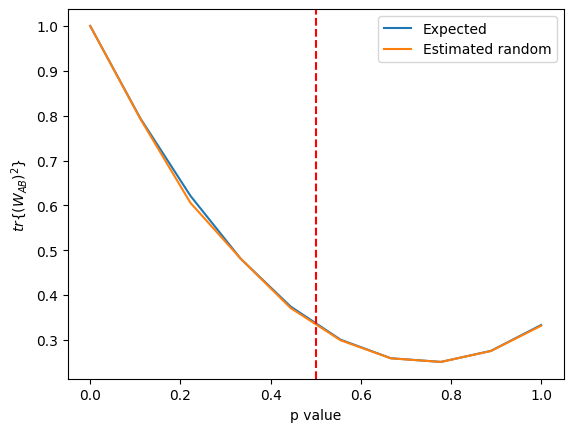

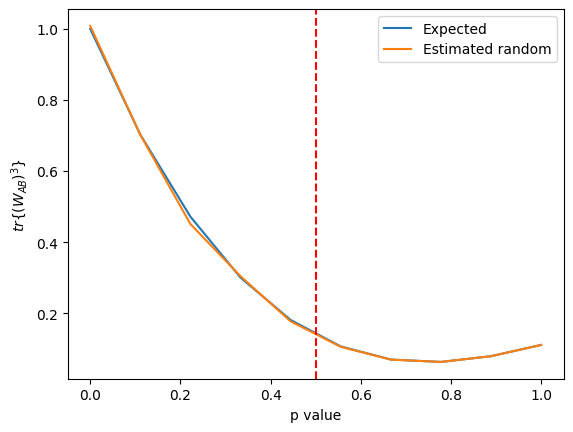

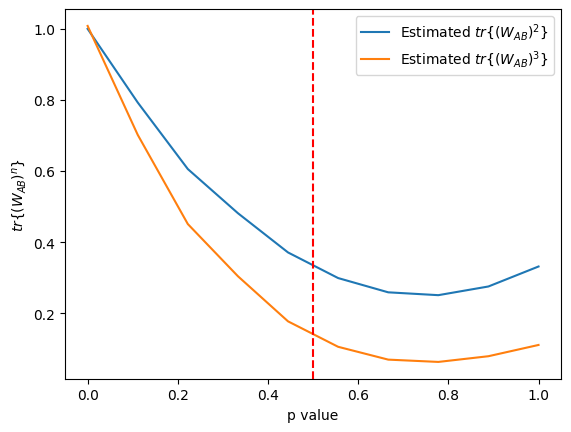

In [38]:
plt.plot(lambdas, lista_expected_p2, label = 'Expected')
plt.plot(lambdas, lista_estimated_p2, label = 'Estimated random')
plt.axvline(x = 1/2, linestyle='dashed', color = 'red')
plt.xlabel('p value')
plt.ylabel(r'$tr\{(W_{AB})^2\}$')
plt.legend()
plt.show()

plt.plot(lambdas, lista_expected_p3, label = 'Expected')
plt.plot(lambdas, lista_estimated_p3, label = 'Estimated random')
plt.axvline(x = 1/2, linestyle='dashed', color = 'red')
plt.xlabel('p value')
plt.ylabel(r'$tr\{(W_{AB})^3\}$')
plt.legend()
plt.show()

plt.plot(lambdas, lista_estimated_p2, label = 'Estimated $tr\{(W_{AB})^2\}$')
plt.plot(lambdas, lista_estimated_p3, label = 'Estimated $tr\{(W_{AB})^3\}$')
plt.axvline(x = 1/2, linestyle='dashed', color = 'red')
plt.xlabel('p value')
plt.ylabel(r'$tr\{(W_{AB})^n\}$')
plt.legend()
plt.show()

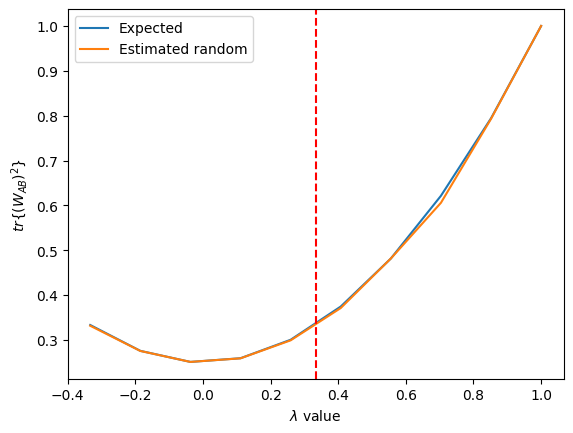

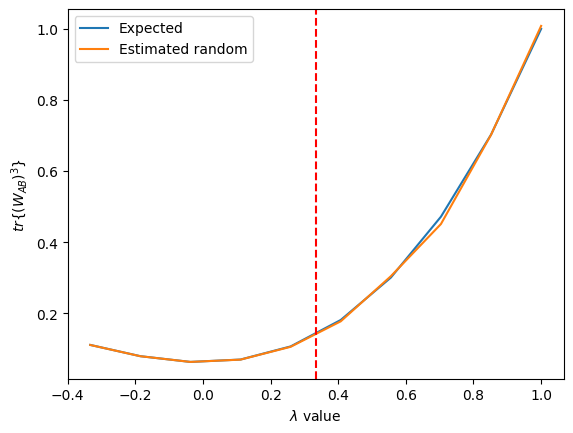

In [39]:
lambdas = np.linspace(0,1,10)
lambdas1 = (3-4*lambdas)/3
plt.plot(lambdas1, lista_expected_p2, label = 'Expected')
plt.plot(lambdas1, lista_estimated_p2, label = 'Estimated random')
plt.axvline(x = 1/3, linestyle='dashed', color = 'red')
plt.xlabel('$\lambda$ value')
plt.ylabel(r'$tr\{(W_{AB})^2\}$')
plt.legend()
plt.show()

plt.plot(lambdas1, lista_expected_p3, label = 'Expected')
plt.plot(lambdas1, lista_estimated_p3, label = 'Estimated random')
plt.axvline(x = 1/3, linestyle='dashed', color = 'red')
plt.xlabel('$\lambda$ value')
plt.ylabel(r'$tr\{(W_{AB})^3\}$')
plt.legend()
plt.show()

So, tr($\rho_{AB}^2$) and tr($\rho_{AB}^3$) can be easily estimated, although we can forshadow a problem again when the state is entangled. However, the difference between the estimated and exact ones are not as big as in the previous example, when we applied the method to the partial transpose of subspace A. In order to check if these errors arise from the randomized nature of the protocol, we are going to test it once again using the Clifford group.

In [2]:
lambdas = np.linspace(0,1,10)        #for p<1/2, the state is entangled. It is separable for p>=1/2.
lista_expected_p2 = []
lista_estimated_p2 = []
for p in lambdas:
    Werner_matrix_TA = np.array([[p/3, 0, 0, (-3+4*p)/6],[0, (3-2*p)/6, 0, 0],[0, 0, (3-2*p)/6, 0],[(-3+4*p)/6, 0, 0, p/3]])

    W2 = Werner_matrix_TA @ Werner_matrix_TA
    exp_p2 = np.trace(W2)
    lista_expected_p2.append(exp_p2)

    print('Expected p2:', exp_p2)

    f = random_renyi2()
    N_A = [0,1]
    N_U = 1000  
    N_M = 1000

    f.Clifford_matrix(Werner_matrix_TA,N_A, N_M)
    estimated_p2 = 2**(-1*f.entropy_value)
    lista_estimated_p2.append(estimated_p2)

    print('Estimated p2:', estimated_p2)

Expected p2: 1.0


[Qibo 0.1.12.dev0|INFO|2023-09-14 11:08:37]: Using qibojit (numba) backend on /CPU:0


Estimated p2: 1.0002552033179013
Expected p2: 0.7942386831275721
Estimated p2: 0.7942131757417139
Expected p2: 0.6213991769547325
Estimated p2: 0.6229677655259427
Expected p2: 0.4814814814814815
Estimated p2: 0.48193747193373937
Expected p2: 0.374485596707819
Estimated p2: 0.3751661690927038
Expected p2: 0.3004115226337449
Estimated p2: 0.30196109886622735
Expected p2: 0.2592592592592593
Estimated p2: 0.2595511131235402
Expected p2: 0.25102880658436216
Estimated p2: 0.2516671330497164
Expected p2: 0.27572016460905346
Estimated p2: 0.2777389624798409
Expected p2: 0.33333333333333337
Estimated p2: 0.33431733415359804


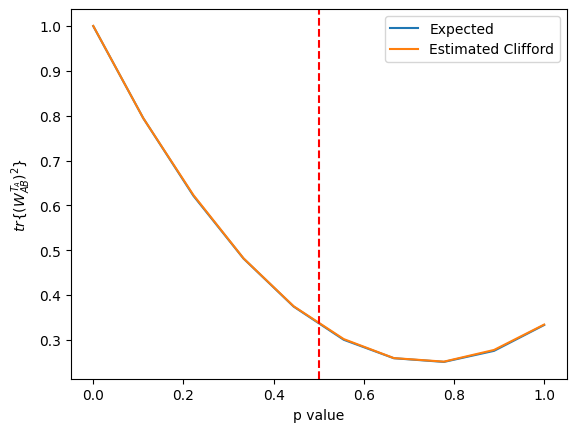

In [6]:
plt.plot(lambdas, lista_expected_p2, label = 'Expected')
plt.plot(lambdas, lista_estimated_p2, label = 'Estimated Clifford')
plt.axvline(x = 1/2, linestyle='dashed', color = 'red')
plt.xlabel('p value')
plt.ylabel(r'$tr\{(W_{AB}^{T_A})^2\}$')
plt.legend()
plt.show()

We can see we obtain the exact value using the Clifford approach. That means somehow our randomized approach does not hold in this entangled regime.

In [7]:
lambdas = np.linspace(0,1,10)        #for p<1/2, the state is entangled. It is separable for p>=1/2.
lista_expected_p2 = []
lista_estimated_p2 = []
for p in lambdas:
    Werner_matrix = np.array([[p/3, 0, 0, 0],[0, (3-2*p)/6, (-3+4*p)/6, 0],[0, (-3+4*p)/6, (3-2*p)/6, 0],[0, 0, 0, p/3]])
    #print(Werner_matrix_TA)

    W2 = Werner_matrix @ Werner_matrix
    exp_p2 = np.trace(W2)
    lista_expected_p2.append(exp_p2)

    print('Expected p2:', exp_p2)

    f = random_renyi2()
    N_A = [0,1]
    N_U = 1000  
    N_M = 1000

    f.Clifford_matrix(Werner_matrix,N_A, N_M)
    estimated_p2 = 2**(-1*f.entropy_value)
    lista_estimated_p2.append(estimated_p2)

    print('Estimated p2:', estimated_p2)

Expected p2: 1.0
Estimated p2: 1.000160164810644
Expected p2: 0.7942386831275718
Estimated p2: 0.7980634697370983
Expected p2: 0.6213991769547325
Estimated p2: 0.6209582788934768
Expected p2: 0.4814814814814815
Estimated p2: 0.48130116729229233
Expected p2: 0.3744855967078189
Estimated p2: 0.37639912871552106
Expected p2: 0.30041152263374493
Estimated p2: 0.30185002125389276
Expected p2: 0.2592592592592593
Estimated p2: 0.2598900033158158
Expected p2: 0.25102880658436216
Estimated p2: 0.2518318141370537
Expected p2: 0.27572016460905346
Estimated p2: 0.27618494629004003
Expected p2: 0.3333333333333333
Estimated p2: 0.33407302520923704


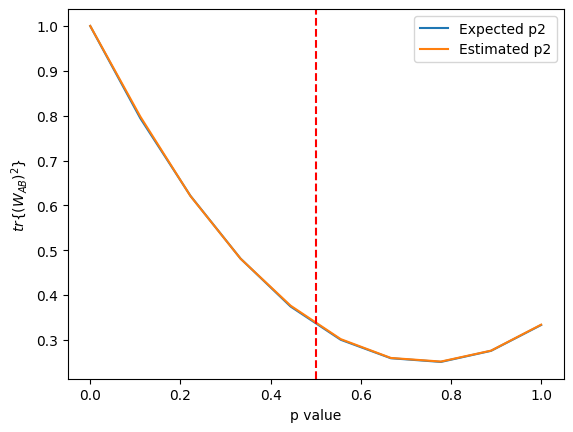

In [8]:
plt.plot(lambdas, lista_expected_p2, label = 'Expected p2')
plt.plot(lambdas, lista_estimated_p2, label = 'Estimated p2')
plt.axvline(x = 1/2, linestyle='dashed', color = 'red')
plt.xlabel('p value')
plt.ylabel(r'$tr\{(W_{AB})^2\}$')
plt.legend()
plt.show()

We found out that the results given by the Clifford group are exact. We have also noticed that the p2 value is equal than the p2_TA, at least it should be. We should prove it analitically.